In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spopt
import scipy.integrate as spint
import scipy.interpolate as spinterp
import pandas as pd
%matplotlib notebook

## Ep. 6: Reading in and plotting SDSS quasar data

*Approach:*
Load the data as done in the carpentry episode. Filter the specified values, and then plot with the code given in the episode.

In [2]:
SDSS_raw = pd.read_csv('sdss_quasars.txt', delim_whitespace=True, engine='python',
                        header=0, index_col=False, na_values='-')

In [3]:
print(SDSS_raw.dtypes,SDSS_raw.shape)

Row                     int64
RA                    float64
DEC                   float64
REDSHIFT              float64
UNIFORM_TARGET          int64
LOGLBOL               float64
LOGLBOL_ERR           float64
R_6CM_2500A           float64
LOGL5100              float64
LOGL5100_ERR          float64
LOGL3000              float64
LOGL3000_ERR          float64
LOGL1350              float64
LOGL1350_ERR          float64
LOGL_BROAD_HA         float64
LOGL_BROAD_HA_ERR     float64
LOGL_NARROW_HA        float64
LOGL_NARROW_HA_ERR    float64
LOGL_BROAD_HB         float64
LOGL_BROAD_HB_ERR     float64
LOGL_NARROW_HB        float64
LOGL_NARROW_HB_ERR    float64
LOGL_OIII_5007        float64
LOGL_OIII_5007_ERR    float64
LOGL_MGII             float64
LOGL_MGII_ERR         float64
LOGL_CIV              float64
LOGL_CIV_ERR          float64
LOGBH                 float64
LOGBH_ERR             float64
dtype: object (10000, 30)


In [4]:
# get rid of NaNs if present
sdss = SDSS_raw[:].dropna(how="any")

# keep only positive values
sdss = sdss[sdss.LOGBH > 0]
sdss = sdss[sdss.LOGLBOL > 0]
sdss = sdss[sdss.LOGL3000 > 0]
sdss = sdss[sdss.LOGL_MGII > 0]      
sdss = sdss[sdss.R_6CM_2500A > 0]

#keep values with errors below 0.1
sdss = sdss[np.abs(sdss.LOGBH_ERR) < 0.2]
sdss = sdss[np.abs(sdss.LOGLBOL_ERR) < 0.1]
sdss = sdss[np.abs(sdss.LOGL3000_ERR) < 0.1]
sdss = sdss[np.abs(sdss.LOGL_MGII_ERR) < 0.1]    

print(sdss.shape)

(474, 30)


<IPython.core.display.Javascript object>


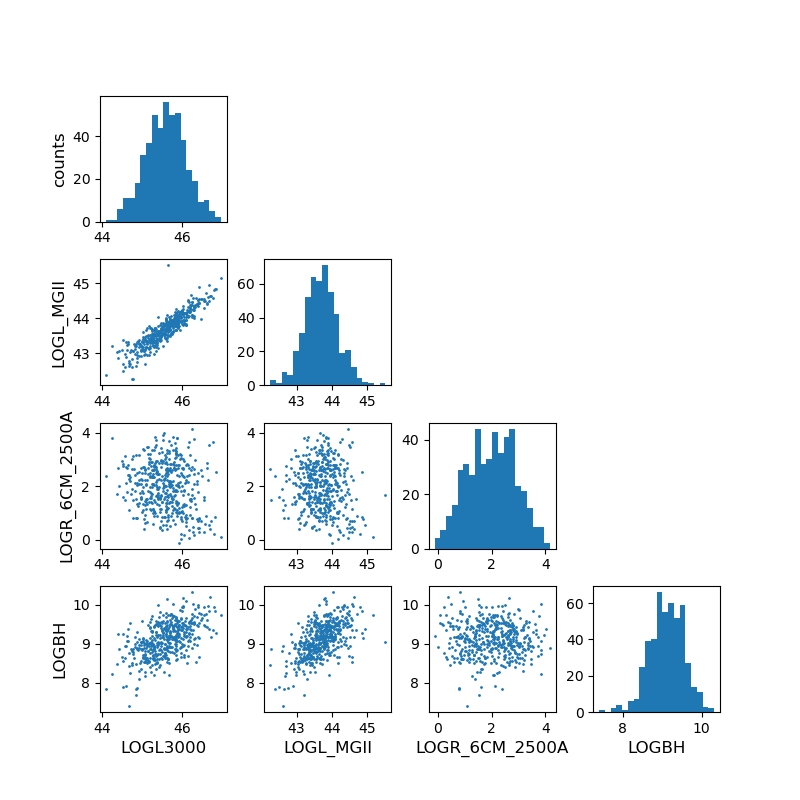

In [5]:
# plots for LOGL3000, LOGL_MGII, R_6CM_2500A and LOGBH
data = np.stack([sdss.LOGL3000, sdss.LOGL_MGII, np.log10(sdss.R_6CM_2500A), sdss.LOGBH])
ndims = 4
labels = ['LOGL3000','LOGL_MGII','LOGR_6CM_2500A','LOGBH']
fig, axes = plt.subplots(4,4,figsize=(8,8))
fig.subplots_adjust(wspace=0.3,hspace=0.3)
for i in range(ndims): ## y dimension of grid
    for j in range(ndims): ## x dimension of grid
        if i == j:
            axes[i,j].hist(data[i], bins=20)
        elif i > j:
            axes[i,j].scatter(data[j], data[i], s=1)
        else:
            axes[i,j].axis('off')
        if j == 0:
            if i == j:
                axes[i,j].set_ylabel('counts',fontsize=12)
            else:
                axes[i,j].set_ylabel(labels[i],fontsize=12)
        if i == 3:
            axes[i,j].set_xlabel(labels[j],fontsize=12)    
plt.show()

<IPython.core.display.Javascript object>


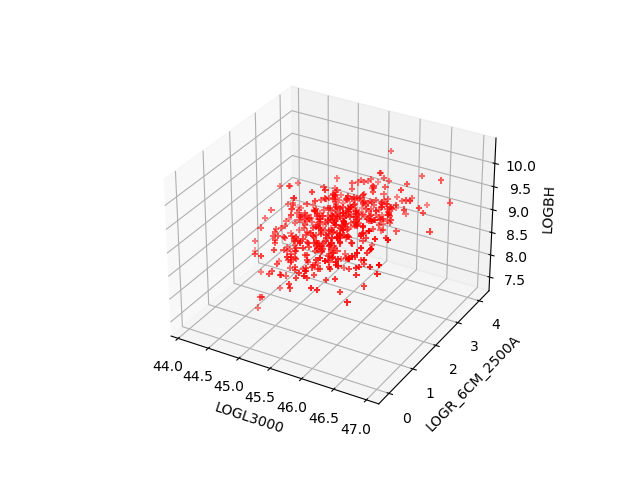

In [6]:
# interactive 3d plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0], data[2], data[3], c="red", marker='+')
ax.set_xlabel('LOGL3000')
ax.set_ylabel('LOGR_6CM_2500A')
ax.set_zlabel('LOGBH')
plt.show()

## Ep.7: Testing for significance

*Approach:*
Perform an independent two-sample t-test to see whether the mean black hole masses from both samples are taken from the same population. When doing the t-test, we asume that the data are distributed normally.

<IPython.core.display.Javascript object>


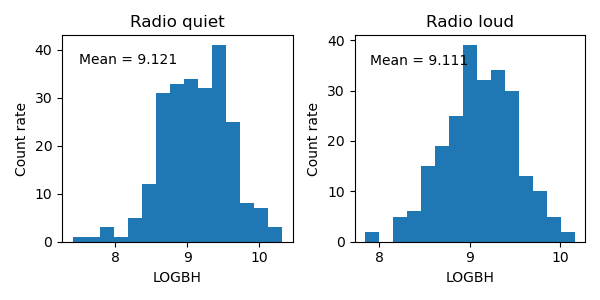

In [7]:
R_median = np.median(sdss.R_6CM_2500A)

# split into two sub-samples
sdss_quiet = sdss[sdss.R_6CM_2500A < R_median]
sdss_loud  = sdss[sdss.R_6CM_2500A >= R_median]
mean_quiet = np.mean(sdss_quiet.LOGBH)
mean_loud  = np.mean(sdss_loud.LOGBH)

# plot histograms of both sub-samples
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.hist(sdss_quiet.LOGBH, bins=15)
ax1.set_ylabel('Count rate')
ax1.set_xlabel('LOGBH')
ax1.set_title('Radio quiet')
ax1.text(7.5,37,f'Mean = {round(mean_quiet, 3)}')
ax2.hist(sdss_loud.LOGBH, bins=15)
ax2.set_ylabel('Count rate')
ax2.set_xlabel('LOGBH')
ax2.set_title('Radio loud')
ax2.text(7.9,35,f'Mean = {round(mean_loud, 3)}')
plt.tight_layout()
plt.show()

From the histograms above, we can see that the data being normally distributed is a reasonable assumption.

In [8]:
# Assumptions: Distributions are normal. Variances drawn from scaled chi^2 distributions
# Null hypothesis: The mean black hole mass from both distributions are drawn from the same population
# Recquire p >= alpha = 0.05

t_test, p_value = sps.ttest_ind(sdss_quiet.LOGBH,sdss_loud.LOGBH, equal_var=True)
print("T =",t_test,"and p-value =",p_value)

T = 0.23877977199232844 and p-value = 0.8113799934746333


The p-value of the t-test performed is high ($p>\alpha=0.05$), so the null hypothesis cannot be rejected.

<IPython.core.display.Javascript object>


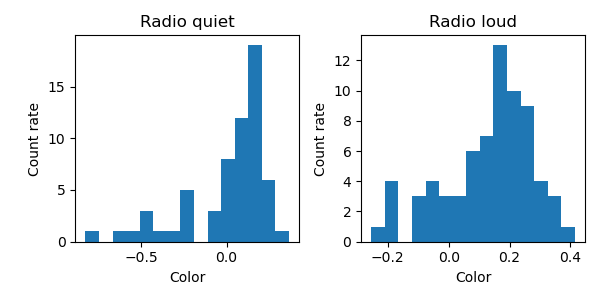

T = -3.4492029651818057 and p-value = 0.0007567816748830864


In [9]:
sdss_quietl = sdss_quiet[sdss_quiet.LOGL1350 > 0]
sdss_loudl  = sdss_loud[sdss_loud.LOGL1350 > 0]
sdss_quietl = sdss_quietl[sdss_quietl.LOGL1350_ERR < 0.1]
sdss_loudl  = sdss_loudl[sdss_loudl.LOGL1350_ERR < 0.1]

color_quiet = sdss_quietl.LOGL1350 - sdss_quietl.LOGL3000
color_loud  = sdss_loudl.LOGL1350 - sdss_loudl.LOGL3000

# plot histograms of both sub-samples
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.hist(color_quiet, bins=15)
ax1.set_ylabel('Count rate')
ax1.set_xlabel('Color')
ax1.set_title('Radio quiet')
ax2.hist(color_loud, bins=15)
ax2.set_ylabel('Count rate')
ax2.set_xlabel('Color')
ax2.set_title('Radio loud')
plt.tight_layout()
plt.show()

# Null hypothesis: The means of the color for both distributions are drawn from the same population
# Recquire p >= alpha = 0.05

t_test, p_value = sps.ttest_ind(color_quiet,color_loud, equal_var=True)
print("T =",t_test,"and p-value =",p_value)

I rule out that the color means are taken from the same population at the 95% confidence level.

*Explanation:* For the first instance, the p-value obtained from the two-sample t-test is much higher than the pre-specified $\alpha$, thus leading to the conclusion that both means are drawn from the same population. The same is not true for the second test performed, on the color of both sub-samples. Here the p-value was lower than $\alpha$, and hence the null hypothesis could be rejected.

## Ep. 8: Finding correlations

*Approach:*
Run Pearson's r and Spearman's $\rho$ tests on all 6 possible combinations of the data. Afterwards, I run a linear regression on the requested parameters for the full sample, as well as for the quiet and loud sub-samples.

In [10]:
def correl_stats(data_a, data_b, only_r=False):
    '''Runs Pearson's r and Spearman's rho tests on provided data'''
    (rcor, rpval) = sps.pearsonr(data_a, data_b)
    (rhocor, rhopval) = sps.spearmanr(data_a, data_b)
    
    print(f"Pearson's r and p-value: {rcor}, {rpval}")
    if not only_r:
        print(f"Spearman's rho and p-value: {rhocor}, {rhopval}")

In [11]:
# Null hypothesis: The data are not correlated
# Recquired: p > 0.05

print('Correlation tests between LOGL3000 and LOGL_MGII')
correl_stats(data[0], data[1])

print('\nCorrelation tests between LOGL3000 and LOGR_6CM_2500A')
correl_stats(data[0], data[2])

print('\nCorrelation tests between LOGL3000 and LOGBH')
correl_stats(data[0], data[3])

print('\nCorrelation tests between LOGL_MGII and LOGR_6CM_2500A')
correl_stats(data[1], data[2])

print('\nCorrelation tests between LOGL_MGII and LOGBH')
correl_stats(data[1], data[3])

print('\nCorrelation tests between LOGR_6CM_2500A and LOGBH')
correl_stats(data[2], data[3])

Correlation tests between LOGL3000 and LOGL_MGII
Pearson's r and p-value: 0.8982712179195194, 1.1492381268680409e-170
Spearman's rho and p-value: 0.915642651199412, 6.223973591888784e-189

Correlation tests between LOGL3000 and LOGR_6CM_2500A
Pearson's r and p-value: -0.169219956833698, 0.00021460136652374508
Spearman's rho and p-value: -0.1445253270194782, 0.0016060283730266196

Correlation tests between LOGL3000 and LOGBH
Pearson's r and p-value: 0.5510235664411556, 5.397474302184091e-39
Spearman's rho and p-value: 0.5327473016579505, 4.1803910915512116e-36

Correlation tests between LOGL_MGII and LOGR_6CM_2500A
Pearson's r and p-value: -0.10803012913350739, 0.018639604409447882
Spearman's rho and p-value: -0.07856822724244446, 0.08751078103072146

Correlation tests between LOGL_MGII and LOGBH
Pearson's r and p-value: 0.5691002748890208, 4.94322160827059e-42
Spearman's rho and p-value: 0.562696947630403, 6.189067633262397e-41

Correlation tests between LOGR_6CM_2500A and LOGBH
Pearso

*Conclusion:* The strongest correlation we see is that between LOGL3000 and LOGLMGII. These have the highest r- and $\rho$-values, as well as extremely low p-values. In the plots above, it is visible that there is a correlation between these two values, as the data-points line up around the same line. The correlations between LOGL3000 and LOGBH, and between LOGL_MGII and LOGBH are weaker, but not rejectable. We see the r- and $\rho$-values are lower than previously, but still point towards a correlation, accompanied by still a relatively low p-value. The correlation between LOGL_MGII and LOGR_6CM_2500A is dubious, but not fully rejectable with 95% confidence. We see that the r-test yielded a lower p-value, but the $\rho$ did not. Lastly, there is the null hypothesis cannot be rejected for the case of LOGR_6CM_2500A and LOGBH, and thus I conclude that these parameters are not correlated.

In [12]:
def lin_regression(x, y, labels):
    '''Performs linear regression on x and y'''
    func = lambda x, a, b: x*a+b
    r2, pcov = spopt.curve_fit(func, x,y, p0=(1,1))
    fig = plt.figure(figsize=(7,4))
    plt.plot(x,y, ".");
    plt.plot(x, r2[0]*x+r2[1], lw=2, label=f'y={round(r2[0],4)}*x + {round(r2[1],4)}' )
    plt.title(f'Linear regresion on {labels[0]} and {labels[1]}')
    plt.xlabel(labels[0], fontsize=14)
    plt.ylabel(labels[1], fontsize=14)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


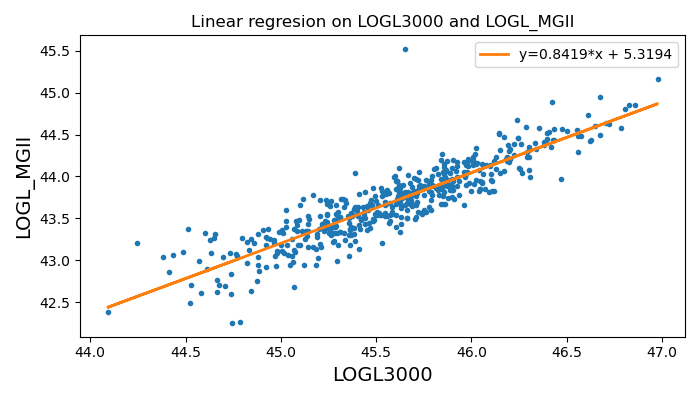

In [13]:
lin_regression(data[0], data[1], ['LOGL3000', 'LOGL_MGII'])

<IPython.core.display.Javascript object>


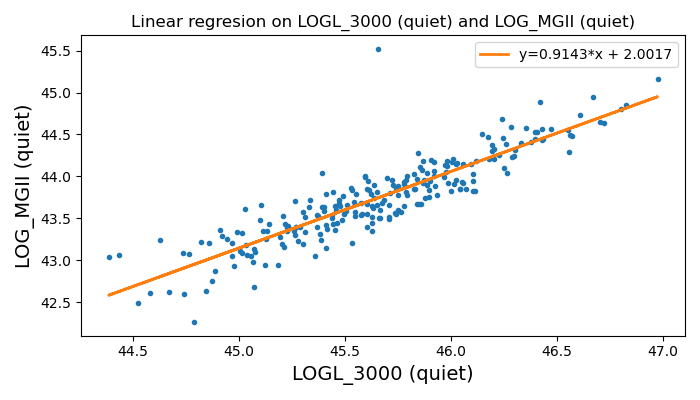

In [14]:
lin_regression(sdss_quiet.LOGL3000, sdss_quiet.LOGL_MGII, ['LOGL_3000 (quiet)', 'LOG_MGII (quiet)'])

<IPython.core.display.Javascript object>


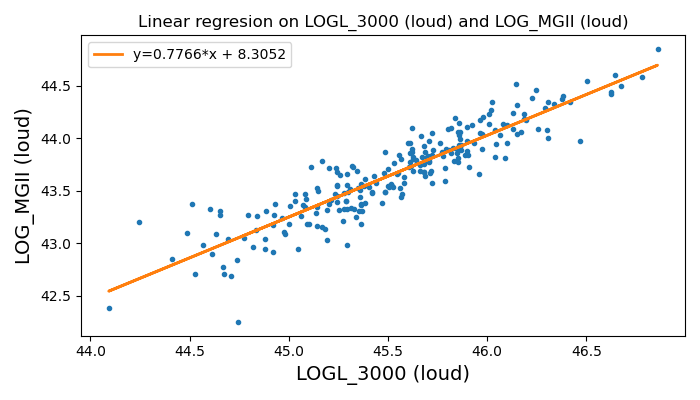

In [15]:
lin_regression(sdss_loud.LOGL3000, sdss_loud.LOGL_MGII, ['LOGL_3000 (loud)', 'LOG_MGII (loud)'])

The linear regressions for the radio-quiet and the radio-loud sub-samples yield differing results. The relationship between both luminosities is different, as the slope is lower for the loud sub-sample than for the quiet. Since the slopes are different, the offset is higher on the loud sub-sample than on the quiet one, since both samples lie on top of each other.

## Ep. 9: Bootstrapping

*Approach:* Create a function that performs the bootstrapping as in the carpentry episode. With the obtained bootstrapped data, I can perform Pearson's r test to obtain the correlation coefficient of a and b. I can also plot both sub-samples' results on the same figure to see whether the relation between  LOGL3000 and LOGL_MGII in both sub-samples is different.

In [16]:
def bootstrapping(x, y):
    '''Perform bootstrapping on x and y to find a and b in linear regression with errors.
    Also print correlation tests of a and b'''
    nsims = 1000
    indices = np.arange(len(x))
    func = lambda x, a, b: x*a+b
    r2, pcov = spopt.curve_fit(func, x,y, p0=(1,1))
    a_obs = r2[0]
    b_obs = r2[1]

    print("The obtained a and b coefficients are ",a_obs,"and",b_obs,"respectively.")

    a_arr = np.zeros(nsims)
    b_arr = np.zeros(nsims)
    for i in range(nsims):
        new_indices = np.random.choice(indices, size=len(x), replace=True)
        new_x = np.take(x,new_indices)
        new_y = np.take(y,new_indices)
        r2, pcov = spopt.curve_fit(func, new_x, new_y, p0=(1,1))
        a_arr[i] = r2[0]
        b_arr[i] = r2[1]
    # perform Pearson's r on a and b
    print('Correlation tests between a and b')
    correl_stats(a_arr, b_arr, only_r=True)
    
    print("The mean and standard deviations of the bootstrapped samples of a are:",
          np.mean(a_arr),"and",np.std(a_arr,ddof=1),"respectively")
    print("The mean and standard deviations of the bootstrapped samples of b are:",
          np.mean(b_arr),"and",np.std(b_arr,ddof=1),"respectively")
    return a_arr, b_arr


In [17]:
a_loud, b_loud = bootstrapping(sdss_quiet.LOGL3000, sdss_quiet.LOGL_MGII)

The obtained a and b coefficients are  0.914266646637246 and 2.001706606190911 respectively.
Correlation tests between a and b
Pearson's r and p-value: -0.9999385959221356, 0.0
The mean and standard deviations of the bootstrapped samples of a are: 0.9115666816803885 and 0.028459261303795988 respectively
The mean and standard deviations of the bootstrapped samples of b are: 2.124844092417372 and 1.3033826892232443 respectively


In [18]:
a_quiet, b_quiet = bootstrapping(sdss_loud.LOGL3000, sdss_loud.LOGL_MGII)

The obtained a and b coefficients are  0.7765572022932274 and 8.30523040324195 respectively.
Correlation tests between a and b
Pearson's r and p-value: -0.9999630510919855, 0.0
The mean and standard deviations of the bootstrapped samples of a are: 0.7776296633194761 and 0.027913796610111348 respectively
The mean and standard deviations of the bootstrapped samples of b are: 8.256392025898691 and 1.2753460257027238 respectively


<IPython.core.display.Javascript object>


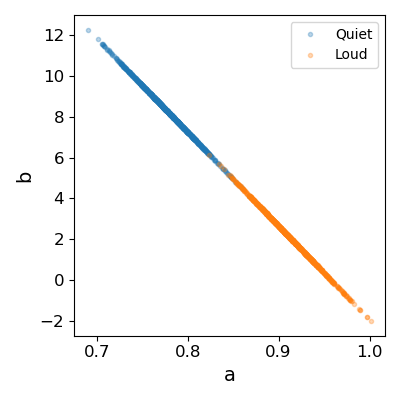

In [19]:
plt.figure(figsize=(4,4))
plt.plot(a_quiet, b_quiet, '.', alpha=0.3, label='Quiet')
plt.plot(a_loud, b_loud, '.', alpha=0.3, label='Loud')
plt.xlabel("a", fontsize=14)
plt.ylabel("b", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend()
plt.tight_layout()
plt.show()

*Conclusion:* From the above figure, we can see that the relation between a and b in lie in the same line, just their location is different. To corroborate this result, we see that the values obtained earlier when performing Pearson's r test indicate a very strong correlation between a and b.